In [16]:
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import scipy.sparse as sparse

import keras as ks

from sklearn.cluster import KMeans
from sklearn import preprocessing

import logging

from tensorrec import TensorRec
from tensorrec.eval import *
from tensorrec.util import append_to_string_at_point

from tensorrec.loss_graphs import WMRBLossGraph,RMSELossGraph

from tensorrec.representation_graphs import (AbstractKerasRepresentationGraph, 
                                             NormalizedLinearRepresentationGraph, 
                                            )

class DeepRepresentationGraph(AbstractKerasRepresentationGraph):

    def create_layers(self, n_features, n_components):
        return [
            ks.layers.Dense(n_components * 16, activation='relu'), 
            ks.layers.Dense(n_components * 8, activation='relu'), 
            ks.layers.Dense(n_components * 2, activation='relu'), 
            ks.layers.Dense(n_components, activation='tanh'),
        ]

In [2]:
# Import Data 
data_order = pd.read_csv('JD_ORDER.csv')
data_sku = pd.read_csv('JD_SKU.csv')
data_user = pd.read_csv('JD_USER.csv')

## TensorRec 
 - A TensorRec system consumes three pieces of data: user_features, item_features, and interactions. It uses this data to learn to make and rank recommendations.

## Interatcion

In [3]:
data_order.replace('-', np.nan)
data_order_null = data_order.isnull().sum()

print("**Numbers of null value in each column:**")
print(data_order_null)
print("**data_order table has", data_order[data_order.duplicated()].shape[0], "rows duplicated**")

data_order_nodup = data_order.drop_duplicates()
data_order_nodup.describe()

**Numbers of null value in each column:**
Unnamed: 0                    0
order_ID                      0
user_ID                       0
sku_ID                        0
order_date                    0
order_time                    0
quantity                      0
type                          0
promise                       0
original_unit_price           0
final_unit_price              0
direct_discount_per_unit      0
quantity_discount_per_unit    0
bundle_discount_per_unit      0
coupon_discount_per_unit      0
gift_item                     0
dc_ori                        0
dc_des                        0
dtype: int64
**data_order table has 0 rows duplicated**


,Unnamed: 0,quantity,type,original_unit_price,final_unit_price,direct_discount_per_unit,quantity_discount_per_unit,bundle_discount_per_unit,coupon_discount_per_unit,gift_item,dc_ori,dc_des
count,59736.000000,59736.000000,59736.000000,59736.000000,59736.000000,59736.000000,59736.000000,59736.000000,59736.000000,59736.000000,59736.000000,59736.000000
mean,29867.500000,1.216452,1.484498,104.849302,72.161648,20.415554,8.364934,0.689686,3.217481,0.168458,12.208300,21.524240
std,17244.442177,1.526712,0.499764,88.000111,65.574409,34.220064,18.564638,6.758612,12.239276,0.374276,14.439516,16.901162
min,0.000000,1.000000,1.000000,0.000000,-32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,14933.750000,1.000000,1.000000,59.000000,33.500000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,5.000000
50%,29867.500000,1.000000,1.000000,79.000000,58.000000,4.000000,0.000000,0.000000,0.000000,0.000000,7.000000,18.000000
75%,44801.250000,1.000000,2.000000,139.900000,98.000000,21.000000,0.000000,0.000000,0.000000,0.000000,10.000000,34.000000
max,59735.000000,150.000000,2.000000,1118.000000,1050.000000,317.000000,200.000000,252.000000,186.000000,1.000000,67.000000,67.000000


In [4]:
data_order_final = data_order_nodup[['user_ID','sku_ID','quantity']]
data_order_final = data_order_final.groupby(['user_ID', 'sku_ID',])['quantity'].sum().unstack().fillna(0)
data_order_final

sku_ID,000d4af39d,00104dbcd7,001b448016,002cf934b4,0037fe285c,00407cdf0c,00556fba9b,0059cabfce,005a5740d0,0074397ac8,...,fef57b2552,fefb33ab03,ff4878ccce,ff5c28bfad,ff6f356b13,ff83aa8a54,ff8b11bf50,ffa3a4bd52,ffaa1699af,fffe1bd280
user_ID,,,,,,,,,,,,,,,,,,,,,
000089d6a6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000bc018b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000d0e5ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0000f81d1b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00012bb423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1fb9c5324b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fb9da04c7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fba172502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Items Features

In [5]:
data_sku
data_sku = data_sku.replace('-', np.nan)
data_sku_null = data_sku.isnull().sum()
print("**Numbers of null value in each column:**")
print(data_sku_null)
print("**data_sku table has", data_sku[data_sku.duplicated()].shape[0], "rows duplicated**")
data_sku_nodup = data_sku.drop_duplicates()
data_sku_nodup.describe()

**Numbers of null value in each column:**
Unnamed: 0            0
sku_ID                0
type                120
brand_ID            120
attribute1         1077
attribute2         1241
activate_date      3439
deactivate_date    3643
dtype: int64
**data_sku table has 0 rows duplicated**


,Unnamed: 0,type
count,3710.000000,3590.000000
mean,1854.500000,1.922841
std,1071.129077,0.266880
min,0.000000,1.000000
25%,927.250000,2.000000
50%,1854.500000,2.000000
75%,2781.750000,2.000000
max,3709.000000,2.000000


In [6]:
sku_features = data_sku_nodup[['sku_ID','type','attribute1','attribute2']].fillna(0)
sku_features.set_index(['sku_ID'], inplace=True)


minmaxscaler = MinMaxScaler()
sku_features_scaled = minmaxscaler.fit_transform(sku_features)
sku_features_scaled = pd.DataFrame(sku_features_scaled)
sku_features_scaled.index = sku_features.index
sku_features_scaled.columns = sku_features.columns

sku_features_scaled

,type,attribute1,attribute2
sku_ID,,,
a234e08c57,0.5,0.75,0.6
6449e1fd87,0.5,0.50,0.5
09b70fcd83,1.0,0.75,0.7
acad9fed04,1.0,0.75,0.7
d66bddc96f,1.0,0.00,1.0
...,...,...,...
a8d3711371,0.0,0.00,0.0
35fecca52d,0.0,0.00,0.0
52cf82af76,0.0,0.00,0.0


## User Features

In [7]:
data_user
data_user_null = data_user.isnull().sum()
print("**Numbers of null value in each column:**")
print(data_user_null)
print("**data_sku table has", data_user[data_user.duplicated()].shape[0], "rows duplicated**")
data_user_nodup = data_user.drop_duplicates()
data_user_nodup.describe()

**Numbers of null value in each column:**
Unnamed: 0           0
user_ID              0
user_level           0
first_order_month    0
plus                 0
gender               0
age                  0
marital_status       0
education            0
city_level           0
purchase_power       0
dtype: int64
**data_sku table has 0 rows duplicated**


,Unnamed: 0,user_level,plus,education,city_level,purchase_power
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,24999.500000,2.374620,0.196020,2.360660,2.063760,1.943620
std,14433.901067,1.084612,0.396988,1.451505,1.335504,1.168995
min,0.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000
25%,12499.750000,1.000000,0.000000,2.000000,1.000000,2.000000
50%,24999.500000,2.000000,0.000000,3.000000,2.000000,2.000000
75%,37499.250000,3.000000,0.000000,3.000000,3.000000,3.000000
max,49999.000000,10.000000,1.000000,4.000000,5.000000,5.000000


In [8]:
data_user_nodup['age'] = pd.factorize(data_user_nodup['age'])[0]
data_user_nodup['gender'] = pd.factorize(data_user_nodup['gender'])[0]
data_user_nodup['marital_status'] = pd.factorize(data_user_nodup['marital_status'])[0]
data_user_nodup

,Unnamed: 0,user_ID,user_level,first_order_month,plus,gender,age,marital_status,education,city_level,purchase_power
0,0,000089d6a6,1,2017-08,0,0,0,0,3,4,3
1,1,0000bc018b,3,2016-06,0,0,1,1,3,2,3
2,2,0000d0e5ab,3,2014-06,0,1,0,1,3,2,2
3,3,0000f81d1b,1,2018-02,0,0,0,1,2,3,2
4,4,00012bb423,4,2008-11,1,0,0,1,4,1,2
...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,1fb9c5324b,4,2015-01,0,1,0,0,3,-1,3
49996,49996,1fb9da04c7,2,2014-12,0,0,0,1,3,2,2
49997,49997,1fba172502,3,2014-08,0,0,0,2,3,1,-1
49998,49998,1fba3a8b80,1,2017-04,0,1,3,0,2,3,3


In [9]:
user_feartures = data_user_nodup[['user_ID', 'user_level', 'plus', 'gender', 'age', 'marital_status', 'education',
                                 'city_level', 'purchase_power']]
user_feartures.set_index(["user_ID"], inplace=True)

maxscaler = MinMaxScaler()
user_feartures_scaled = minmaxscaler.fit_transform(user_feartures)
user_feartures_scaled = pd.DataFrame(user_feartures_scaled)
user_feartures_scaled.index = user_feartures.index
user_feartures_scaled.columns = user_feartures.columns
user_feartures_scaled

,user_level,plus,gender,age,marital_status,education,city_level,purchase_power
user_ID,,,,,,,,
000089d6a6,0.181818,0.0,0.0,0.0,0.0,0.8,0.833333,0.666667
0000bc018b,0.363636,0.0,0.0,0.2,0.5,0.8,0.500000,0.666667
0000d0e5ab,0.363636,0.0,1.0,0.0,0.5,0.8,0.500000,0.500000
0000f81d1b,0.181818,0.0,0.0,0.0,0.5,0.6,0.666667,0.500000
00012bb423,0.454545,1.0,0.0,0.0,0.5,1.0,0.333333,0.500000
...,...,...,...,...,...,...,...,...
1fb9c5324b,0.454545,0.0,1.0,0.0,0.0,0.8,0.000000,0.666667
1fb9da04c7,0.272727,0.0,0.0,0.0,0.5,0.8,0.500000,0.500000
1fba172502,0.363636,0.0,0.0,0.0,1.0,0.8,0.333333,0.000000


In [10]:
data_user_temp = data_order_final.join(user_feartures_scaled, on=None, how='left', lsuffix='', rsuffix='', sort=False)
user_feartures_scaled = data_user_temp.iloc[:,-8:]
user_feartures_scaled

,user_level,plus,gender,age,marital_status,education,city_level,purchase_power
user_ID,,,,,,,,
000089d6a6,0.181818,0.0,0.0,0.0,0.0,0.8,0.833333,0.666667
0000bc018b,0.363636,0.0,0.0,0.2,0.5,0.8,0.500000,0.666667
0000d0e5ab,0.363636,0.0,1.0,0.0,0.5,0.8,0.500000,0.500000
0000f81d1b,0.181818,0.0,0.0,0.0,0.5,0.6,0.666667,0.500000
00012bb423,0.454545,1.0,0.0,0.0,0.5,1.0,0.333333,0.500000
...,...,...,...,...,...,...,...,...
1fb9c5324b,0.454545,0.0,1.0,0.0,0.0,0.8,0.000000,0.666667
1fb9da04c7,0.272727,0.0,0.0,0.0,0.5,0.8,0.500000,0.500000
1fba172502,0.363636,0.0,0.0,0.0,1.0,0.8,0.333333,0.000000


Now we hava three tables:

User_Feature : User_features_scaled 

Sku_Feature  : Sku_features_scaled  

Interaction. : Data_order_final     

In [11]:
interaction_f = sparse.coo_matrix(data_order_final)
user_f  = sparse.coo_matrix(user_feartures_scaled) 
item_f  = sparse.coo_matrix(sku_features_scaled) 

In [12]:
def interaction_masking(interactions):
    '''
    This function will "mask" (a.k.a "hide") 20% of original interactions
    Masked items wil be considered not purchased

    '''
    mask_size = len(interactions.data)
    mask = np.random.choice(a=[False, True], size=mask_size, p=[.2, .8])
    not_mask = np.invert(mask)

    train_interactions = sparse.coo_matrix((interactions.data[mask],
                                        (interactions.row[mask],
                                         interactions.col[mask])),
                                       shape=interactions.shape)

    test_interactions = sparse.coo_matrix((interactions.data[not_mask],
                                       (interactions.row[not_mask],
                                        interactions.col[not_mask])),
                                      shape=interactions.shape)

    return train_interactions, test_interactions

In [13]:
mask_size = len(interaction_f.data)

np.random.choice(a=[False, True], 
                 size=mask_size, 
                 p=[.2, .8])

array([ True,  True,  True, ...,  True,  True, False])

In [14]:
train_interactions, test_interactions = interaction_masking(interaction_f)

# Feed the user and item features
user_features  = user_f
item_features = item_f

In [15]:
train_interactions

<49712x3710 sparse matrix of type '<class 'numpy.float64'>'
	with 46296 stored elements in COOrdinate format>

In [ ]:
import sys
loggers = logging.getLogger()
fh = logging.FileHandler('test.log')
formats = logging.Formatter('%(message)s')
fh.setFormatter(formats)
loggers.addHandler(fh)
pl = logging.StreamHandler(sys.stdout)
loggers.addHandler(pl)
loggers.setLevel(logging.INFO)

In [23]:
%%time
### call %%time to see the time it takes to run the model 

## model parameters

n_components =  10 
biased = False

epochs = 10
fit_kwargs = {'epochs': 1, 'alpha': 0.01, 'verbose': True, 'learning_rate': .01,
              'n_sampled_items': int(item_features.shape[0] * .1)}

model = TensorRec(n_components = n_components,                 
                  user_repr_graph = DeepRepresentationGraph(),
                   item_repr_graph = NormalizedLinearRepresentationGraph(),
                   loss_graph = WMRBLossGraph(), 
                  biased=biased)

log = []
for epoch in range(epochs):
    model.fit_partial(interactions=train_interactions,
                      user_features=user_features,
                      item_features=item_features,
                      **fit_kwargs)
    
    log.append(logging.info("Finished epoch {}".format(epoch)))


INFO:root:Processing interaction and feature data
/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
INFO:root:Beginning fitting
INFO:root:EPOCH 0 BATCH 0 loss = 8.218557357788086, weight_reg_l2_loss = 0.8496572875976562, mean_pred = 0.06592677533626556
INFO:root:Finished epoch 0
INFO:root:Processing interaction and feature data
INFO:root:Beginning fitting
INFO:root:EPOCH 0 BATCH 0 loss = 8.217207908630371, weight_reg_l2_loss = 0.7198484802246093, mean_pred = 0.17336931824684143
INFO:root:Finished epoch 1
INFO:root:Processing interaction and feature data
INFO:root:Beginning fitting
INFO:root:EPOCH 0 BATCH 0 loss = 8.21599006652832, weight_reg_l2_loss = 0.6054452896118164, mean_pred = 0.26481306552886963
INFO:root:Finished epoch 2
INFO:root:

CPU times: user 9min 54s, sys: 4min 34s, total: 14min 29s
Wall time: 13min 30s


In [18]:
predictions = model.predict(user_features=user_features,
                             item_features=item_features)

In [19]:
# produce the ranking into a readable table (dataframe it is)
ranks_df = pd.DataFrame(predictions)
ranks_df.columns = sku_features_scaled.index
ranks_df.index = user_feartures_scaled.index
ranks_df = ranks_df.T

In [20]:
ranks_df

user_ID,000089d6a6,0000bc018b,0000d0e5ab,0000f81d1b,00012bb423,00015ff032,0001aa7059,0001bbdc89,0001dc70f4,0001f75444,...,1fb813187a,1fb87469bf,1fb88db1e0,1fb8abba2a,1fb8b519ee,1fb9c5324b,1fb9da04c7,1fba172502,1fba3a8b80,1fba719c6e
sku_ID,,,,,,,,,,,,,,,,,,,,,
a234e08c57,0.815634,0.868561,0.861045,0.780246,0.930959,0.956526,0.915158,0.839681,0.996384,0.838692,...,0.838257,0.706361,0.739073,0.908817,0.996384,0.806347,0.799362,0.760848,0.904061,0.744083
6449e1fd87,0.908637,0.972119,0.967186,0.869872,1.040429,1.069598,1.023562,0.937567,1.114074,0.935774,...,0.936071,0.786031,0.825716,1.017160,1.114074,0.909109,0.893509,0.852731,1.009992,0.828775
09b70fcd83,0.957682,1.027413,1.021132,0.916861,1.098618,1.128046,1.081764,0.988838,1.177647,0.987090,...,0.987637,0.826999,0.870564,1.075390,1.177647,0.960287,0.943040,0.899925,1.064372,0.872810
acad9fed04,0.957682,1.027413,1.021132,0.916861,1.098618,1.128046,1.081764,0.988838,1.177647,0.987090,...,0.987637,0.826999,0.870564,1.075390,1.177647,0.960287,0.943040,0.899925,1.064372,0.872810
d66bddc96f,0.949404,1.026463,1.035079,0.911117,1.095052,1.130191,1.078371,0.985883,1.172182,0.981371,...,0.983978,0.820815,0.870474,1.073322,1.172182,0.983643,0.941706,0.906693,1.065384,0.866650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a8d3711371,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35fecca52d,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
52cf82af76,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
ranks_df_T = ranks_df.T
nlargest = 5
order = np.argsort(-ranks_df_T.values, axis=1)[:, :nlargest]
result = pd.DataFrame(ranks_df_T.columns[order], 
                      columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=ranks_df_T.index)

/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


In [22]:
result

,top1,top2,top3,top4,top5
user_ID,,,,,
000089d6a6,bba0a95bda,44365ea339,1dab34d6b7,9589d3f054,a283b57f02
0000bc018b,bba0a95bda,44365ea339,d7ce14a520,348d198012,5bfeec5002
0000d0e5ab,2a8dd18e45,23ee437662,5bfeec5002,8fc989b6ce,631166a9b8
0000f81d1b,44365ea339,bba0a95bda,56f7fc9e78,21c4955c54,d7ce14a520
00012bb423,bba0a95bda,44365ea339,d7ce14a520,348d198012,5bfeec5002
...,...,...,...,...,...
1fb9c5324b,b237296a83,631166a9b8,535d640b13,aabc2458f7,8fc989b6ce
1fb9da04c7,bba0a95bda,44365ea339,631166a9b8,ff8b11bf50,56f7fc9e78
1fba172502,7ad986a2e8,8fc989b6ce,23ee437662,aabc2458f7,709a8c7508


In [40]:
r_at_k_test = recall_at_k(predictions, test_interactions, k=1500)
r_at_k_train = recall_at_k(predictions, train_interactions, k=1500)
print("Recall at @k: Train: {:.2f} Test: {:.2f}".format(r_at_k_train.mean(), r_at_k_test.mean()))

Recall at @k: Train: 0.97 Test: 0.97


In [37]:
import re
fp =open('test.log')
p = re.compile(r'(?<=weight_reg_l2_loss = )\s*\d*\.\d*')

out = []
for line in fp.readlines():
    s = p.findall(line)
    if s:
        out.append(float(s[0]))
fp.close()

print(out)

[0.8496572875976562, 0.7198484802246093, 0.6054452896118164, 0.5058528137207031, 0.42006687164306644, 0.34694366455078124, 0.2854076194763184, 0.23441377639770508, 0.19290563583374024, 0.15982892036437987]


<Figure size 432x288 with 0 Axes>

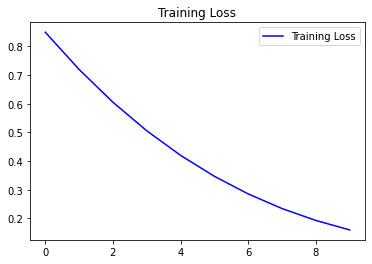

<Figure size 432x288 with 0 Axes>

In [38]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), out, 'b', label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.figure()